## Failure analysis example

Let's consider a fixed-wing glider with simplified flat-plate dynamics restricted to the $xz$ plane. The state of the system is position, orientation of the glider body, elevator angle $\phi$, and spatial velocity.

$$x = [x, z, \theta, \phi, v_x, v_z, \dot{\theta}]^T$$

and control inputs for the desired rate of change of the elevator angle $u = [\dot{\phi}]$. These dynamics are based on the glider dynamics from [this notebook](https://deepnote.com/workspace/Underactuated-2ed1518a-973b-4145-bd62-1768b49956a8/project/System-Identification-for-the-Perching-Glider-d326e0f0-cd2d-4184-9308-0496512308fc/notebook/glider_sysid-f861b6e776ce4aa2b1bb62257373947f).

In [1]:
using Plots
using Gen
using LinearAlgebra
using Printf
using DelimitedFiles
using Random

In [2]:
# Global physical parameters
m = 0.08 # body mass.
Sw = 0.0885 # surface area of wing + fuselage + tail.
Se = 0.0147 # surface area of elevator.
I = 0.0015 # body inertia.
lw = 0 # horizontal offset of wing center.
le = 0.022 # elevator aerodynamic center from hinge.
lh = 0.27 # elevator hinge.
rho = 1.204 # air density (kg/m^3).
g = 9.81; # gravity.

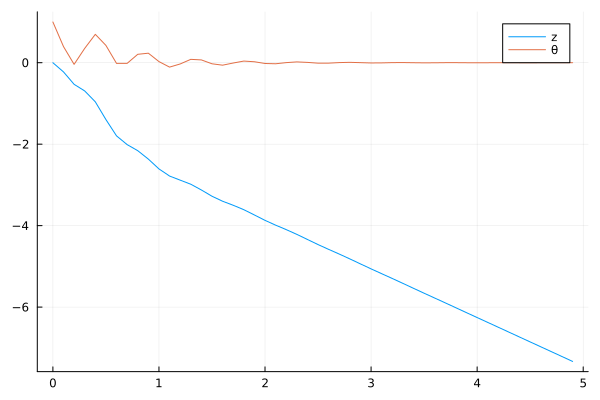

In [3]:
function plate_aero_force(
        cop_velocity::Vector{Float64},
        normal::Vector{Float64},
        surface_area::Float64,
    )
    """
    Compute the force acting on a flat plate.
    
    args:
        cop_velocity: [x, z] velocity of the center of pressure of the plate (m/s)
        cop_velocity: [x, z] unit normal to the plate
        surface_area: surace area of the plate (m^2)
        rho: density of air (kg/m^3)
    returns:
        [fx, fz] force on the plate
    """
    speed = sqrt(sum(cop_velocity .^ 2))
    force = -rho * surface_area * (transpose(normal) * cop_velocity) * speed
    return force
end;

function get_forces_on_glider(
        state::Vector{Float64},
        u::Vector{Float64},
    )
    
    """
    Compute the forces acting on the glider.
    
    args:
        state: [x, z, theta, phi, vx, vz, theta_dot]
        u: [phi_dot] control input
    """
    x, z, theta, phi, vx, vz, theta_dot = state
    
    # Get forces on the wing
    v_wing = [
        vx + lw * theta_dot * sin(theta),
        vz + lw * theta_dot * cos(theta)
    ]
    n_wing = [sin(theta), cos(theta)]
    f_wing = plate_aero_force(v_wing, n_wing, Sw)
    
    # Get forces on the elevator
    elevator_angle = theta + phi
    elevator_angle_dot = theta_dot + u[1]
    v_elevator = [
        vx + lh * theta_dot * sin(theta) + le * elevator_angle_dot * sin(elevator_angle),
        vz + lh * theta_dot * cos(theta) + le * elevator_angle_dot * cos(elevator_angle),
    ]
    n_elevator = [sin(elevator_angle), cos(elevator_angle)]
    f_elevator = plate_aero_force(v_elevator, n_elevator, Se)
    
    return f_wing, f_elevator
end;

function next_state(
        state::Vector{Float64},
        u::Vector{Float64},
        dt::Float64,
        disturbance::Vector{Float64},
    )
    
    """
    Compute the next state of the glider
    
    args:
        state: [x, z, theta, phi, vx, vz, theta_dot]
        u: [phi_dot] control input
        dt: timestep for integration
        disturbance: [fx, fz, tau] disturbance wrench
    """
    x, z, theta, phi, vx, vz, theta_dot = state
    state_dot = fill(0.0, size(state))
    
    # Positions update via velocities
    state_dot[1:3] = state[5:end]
    state_dot[4] = u[1]
    
    # Get accelerations
    f_wing, f_elevator = get_forces_on_glider(state, u)
    a_x = 1 / m * (
        f_wing * sin(theta) + f_elevator * sin(theta + phi)
        + disturbance[1]
    )
    a_z = -g + 1 / m * (
        f_wing * cos(theta) + f_elevator * cos(theta + phi)
        + disturbance[2]
    )
    theta_ddot = 1 / I * (
        f_wing * lw + f_elevator * (lh * cos(phi) + le)
        + disturbance[3]
    )
    
    state_dot[5] = a_x
    state_dot[6] = a_z
    state_dot[7] = theta_ddot
    
    next_state = state .+ dt * state_dot
    
    # Enforce limits on elevator angle
    next_state[4] = clamp(next_state[4], -pi / 3, pi / 3)
    
    return next_state
end;

function next_state_substepped(
        state::Vector{Float64},
        u::Vector{Float64},
        dt::Float64,
        substeps::Int,
        disturbance::Vector{Float64},
    )
    
    """
    Compute the next state of the glider using multiple substeps
    
    args:
        state: [x, z, theta, phi, vx, vz, theta_dot]
        u: [phi_dot] control input
        dt: timestep for integration
        substeps: break the integration into this many forward Euler steps
        disturbance: [fx, fz, tau] disturbance wrench
    """
    dt_substep = dt / substeps
    for i=1:substeps
        state = next_state(state, u, dt_substep, disturbance)
    end
    return state
end

function control_policy(observation::Vector{Float64})
    """Define a control policy for level flight"""
    theta, theta_dot = observation
    
    # Control elevator angle
    phi_dot = (
        3.0 * theta + 1.0 * theta_dot # PD stabilization for angle
    )
    
    return [phi_dot]
end;

# Let's simulate to see how this model + controller works!
x = [0.0, 0.0, 1.0, 0.0, 10.0, 0.0, 0.0]
obs_indices = [3, 7]
d = fill(0.0, 3)  # no disturbance for now
steps = 50
dt = 0.1
substeps = 10
xs = zeros(steps, 7)
xs[1, :] = x
for i in range(2, stop=steps)
    u = control_policy(x[obs_indices])
    x = next_state_substepped(x, u, dt, substeps, d)
    xs[i, :] = x
end

t_range = range(0.0, (steps - 1) * dt, step=dt)
plot(t_range, xs[:, 2:3], label=["z" "θ"])
# plot(xs[:, 1], xs[:, 2], xlabel="x", ylabel="z")

In [4]:
# This isn't very interesting, so let's add the possibility
# of failures in the controls
# Now let's wrap this into a generative model for Gen

# Also use the unfold structure
struct State
    x::Vector{Float64}
    elevator_failure::Bool
end

@gen (static) function integration_substep(
        t::Int,
        x::Vector{Float64},
        u::Vector{Float64},
        disturbance::Vector{Float64},
        dt::Float64,
    )::Vector{Float64}    
    return next_state(x, u, dt, disturbance)
end

integration_step = Gen.Unfold(integration_substep);

@gen (static) function kernel(
        t::Int,
        state::State,
        elevator_failure_probability::Float64,
        elevator_repair_probability::Float64,
        disturbance_force_cov::Matrix{Float64},
        observation_noise_cov::Matrix{Float64},
    )
    x = state.x
    elevator_failure = state.elevator_failure 
    
    elevator_update_probability = elevator_failure ? 1 - elevator_repair_probability : elevator_failure_probability
    next_elevator_failure = {:elevator_failure} ~ bernoulli(elevator_update_probability)
    
    # Get disturbance
    disturbance ~ mvnormal(fill(0.0, 3), disturbance_force_cov)
    
    # Make observations about pose and make a control decision based on that
    obs ~ mvnormal(x[obs_indices], observation_noise_cov)
    
    # Evaluate the policy
    u = control_policy(obs)
    
    # Apply failures
    elevator_input = elevator_failure ? 0.1 * u[1] : u[1]

    substeps = 10
    dt = 0.1
    x_substeps = integration_step(
        substeps,
        x,
        [elevator_input],
        disturbance,
        dt / substeps
    )
    x_next = x_substeps[end]
    
    return State(x_next, next_elevator_failure)
end

chain_fn = Gen.Unfold(kernel);

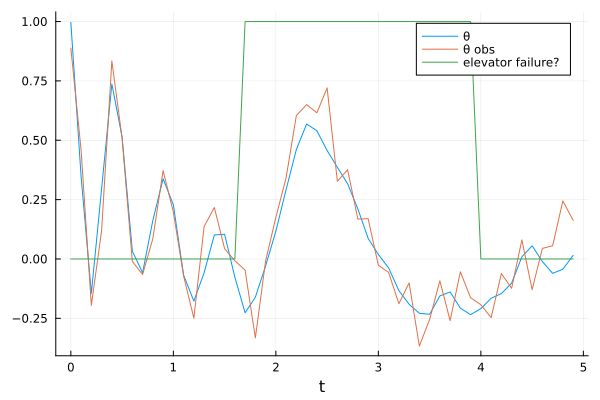

In [11]:
@gen (static) function flight_model_with_failure(steps::Int)
    # Simulate flight with the defined dynamics model and controller,
    # now with the option for spicy failures!
    
    # args:
    #    timesteps: number of steps to simulate
    # Define the initial state
    initial_state_mean = [0.0, 0.0, 1.0, 0.0, 10.0, 0.0, 0.0]
    initial_state_cov = diagm(fill(1e-2, 7))
    x0 ~ mvnormal(initial_state_mean, initial_state_cov)
    
    # Define process and observation noise characteristics
    disturbance_force_cov = diagm(fill(1e-4, 3))
    observation_noise_cov = diagm(fill(1e-2, length(obs_indices)))
    
    # Define the failure characteristics
    elevator_failure_probability = 0.01
    elevator_repair_probability = 0.05

    # Simulate
    initial_state = State(x0, false)
    chain ~ chain_fn(
        steps,
        initial_state,
        elevator_failure_probability,
        elevator_repair_probability,
        disturbance_force_cov,
        observation_noise_cov,
    )
    
    # Return observations of just the position and angle
    return chain
end;

function render(trace; overlay=false)
    T = Gen.get_args(trace)[1]
    obs = Matrix{Float64}(undef, T, length(obs_indices))
    for t=1:T
        obs[t, :] = trace[:chain => t => :obs]
    end
    elevator_failure = [trace[:chain => t => :elevator_failure] for t=1:T]
    
    state = Matrix{Float64}(undef, T, 7)
    chain = Gen.get_retval(trace)
    state[1, :] = trace[:x0]
    for t=2:T
        state[t, :] = chain[t-1].x
    end
    
    f = overlay ? plot! : plot
    dt = 0.1
    t_range = range(0.0, (T - 1) * dt, step=dt)
    plt = plot(t_range, state[:, 3], xlabel="t", label="θ")
    plot!(t_range, obs[:, 1], xlabel="t", label="θ obs")
    plot!(t_range, elevator_failure, label="elevator failure?")

    return plt
end;

Gen.@load_generated_functions # To allow use of the generative function written in the static modeling language above.

# Now let's simulate that and see what happened
steps = 50
trace = Gen.simulate(flight_model_with_failure, (steps,))
observed = Matrix{Float64}(undef, (steps, length(obs_indices)))
for t=1:steps
    observed[t, :] = trace[:chain => t => :obs]
end
gt_trace = trace
render(trace)

In [12]:
function consensus(estimated_failures)
    T = size(estimated_failures, 1)
    N = size(estimated_failures, 2)
    prob_elevator_failure = Vector{Float64}(undef, T)

    for t=1:T
        prob_elevator_failure[t] = sum([estimated_failures[t, i] for i=1:N]) / N
    end
    
    return prob_elevator_failure
end

function plot_consensus(observed_values, estimated_states, estimated_failures; label=true)
    # Plot the observed trajectory
    T = size(estimated_states, 1)
    N = size(estimated_states, 2)
    dt = 0.1
    t_range = range(0.0, (T - 1) * dt, step=dt)
    fig = plot(color=:black, alpha=0.1, label="θ (estimated)", legend=label, legend_position=:topleft)
    
    prob_elevator_failure = consensus(estimated_failures)
    
    # Plot failure estimates
    plot!(t_range, prob_elevator_failure, label="P(elevator failed)")
    
    # Plot state estimates
    for i = 1:N
        plot!(t_range, estimated_states[:, i, 3], xlabel="t", label=nothing, color=:black, alpha=0.1)
    end
    
    # Plot ground truth failure
    elevator_failure = [gt_trace[:chain => t => :elevator_failure] for t=1:T]
    plot!(t_range, elevator_failure, label="Elevator failure (GT)")
    
    # Plot ground truth states
    gt_state = Matrix{Float64}(undef, T, 7)
    chain = Gen.get_retval(gt_trace)
    gt_state[1, :] = trace[:x0]
    for t=2:T
        gt_state[t, :] = chain[t-1].x
    end
    plot!(t_range, gt_state[:, 3], label="θ (GT)", color=:red)
    
    # Plot observations
    plot!(t_range, observed_values[:, 1], label="θ (observed)", color=:red, linestyle=:dash)
    
    return fig
end;

The question is: can we infer where the failures occurred without using the ground truth labels?

avg_runtime = 12.631621553


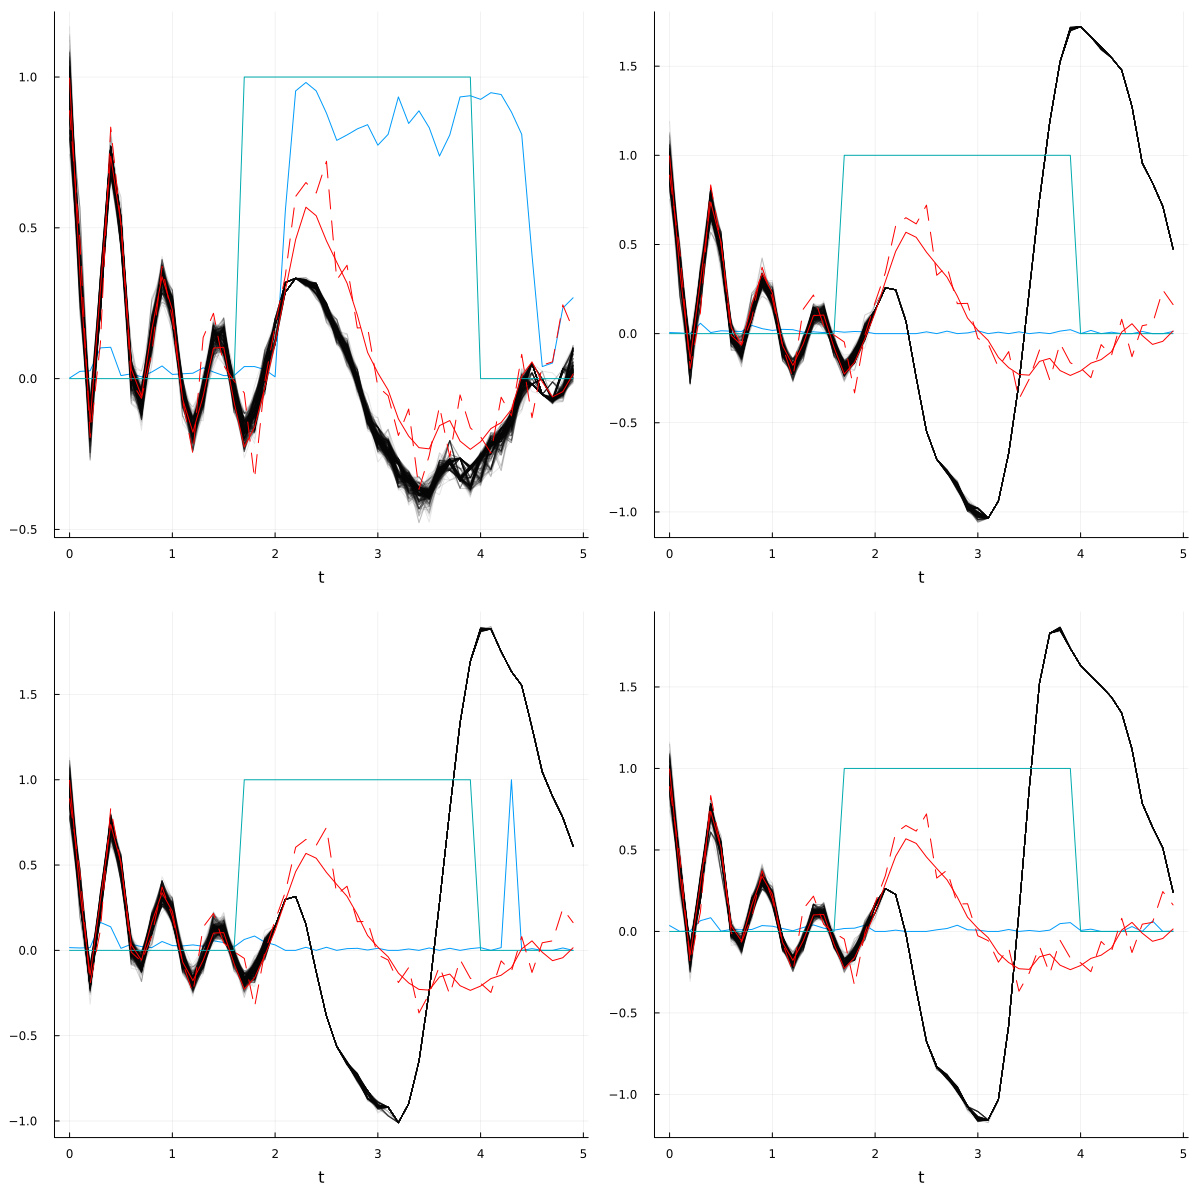

In [15]:
@gen function perturbation_proposal(prev_trace, a::Int, b::Int)
    disturbance_drift_cov = diagm(fill(2e-4, 3))
    for t=a:b
        # Re-sample a disturbance from around the previous value
        new_disturbance = {:chain => t => :disturbance} ~ mvnormal(
            prev_trace[:chain => t => :disturbance],
            disturbance_drift_cov,
        )
    end
end

function perturbation_move(trace, a::Int, b::Int)
    Gen.metropolis_hastings(trace, perturbation_proposal, (a, b))
end;


function particle_filter(num_particles::Int, observed::Matrix{Float64}, num_samples::Int)
    # Create a list to store the estimated states
    T = size(observed, 1)
    n_states = 7
    n_failures = 1
    estimated_states = Array{Float64}(undef, T, num_samples, n_states)
    estimated_failures = Array{Bool}(undef, T, num_samples, n_failures)
    ess = Array{Float64}(undef, T)  # effective sample size
    
    # Initialize the particle filter
    init_obs = Gen.choicemap()  # (:chain => 1 => :obs, observed[1, :])
    state = Gen.initialize_particle_filter(flight_model_with_failure, (0,), init_obs, num_particles)

    acceptance_rate = 0.0
    resample_rate = 0.0
    for t=1:T
        # Save the current effective sample size, as a fraction of total number of particles
        _, log_normalized_weights = Gen.normalize_weights(state.log_weights)
        ess[t] = Gen.effective_sample_size(log_normalized_weights) / num_particles

        # Update the particle filter
        resample_rate += Gen.maybe_resample!(state, ess_threshold=num_samples) / T
        observations = Gen.choicemap((:chain => t => :obs, observed[t, :]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), observations)

        # Save the current estimate
        particles = Gen.sample_unweighted_traces(state, num_samples)
        for i=1:num_samples
            if t == 1
                # At the first timestep, we need x0
                estimated_states[t, i, :] = particles[i][:x0]
            else
                # At all further timesteps, we want the second-to-last state, since
                # this is the last state that received an observation
                estimated_states[t, i, :] = Gen.get_retval(particles[i])[end - 1].x
            end
            estimated_failures[t, i, 1] = particles[i][:chain => t => :elevator_failure]
        end
        
#         # apply a rejuvenation move to each particle
#         for i=1:num_particles
#             window = 1
#             t_min = max(1, t - window)
#             state.traces[i], accept  = perturbation_move(state.traces[i], t_min, t)
#             acceptance_rate += accept / (num_particles * T)
#         end
    end
#     @show acceptance_rate
#     @show resample_rate

    # return the history of estimates
    return estimated_states, estimated_failures, ess
end;

N_particles = 4000
N_samples = 500
N_trials = 4
function run_and_plot(i)
    estimated_states, estimated_failures, ess = particle_filter(N_particles, observed, N_samples);
    return plot_consensus(observed, estimated_states, estimated_failures, label=false)
end
avg_runtime = (@elapsed figs = map(run_and_plot, 1:N_trials)) / N_trials
@show avg_runtime
gr(size = (1200, 1200))
Plots.plot(figs..., fmt = :png)